In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas
import matplotlib.pyplot as plt

import seaborn as sns
#settings
%reload_ext autoreload
%autoreload 3
%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["axes.titlesize"] = 15
plt.rcParams['savefig.dpi'] = 1200

tf.keras.utils.set_random_seed(2) # relu

In [26]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
   x_data, y_data = [], []
   for i in range(look_back, len(dataset)-1):
      a = dataset[i-look_back:i, 0]
      x_data.append(a)
      b = dataset[i, 0]
      y_data.append(b)
   return np.array(x_data), np.array(y_data)

In [27]:
# load the dataset
df = pd.read_csv('data/airline-passengers.csv', usecols=[1], engine='python')
dataset = df.to_numpy()
dataset = dataset.astype('float32') # more suitable for NNs

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# normalize the dataset
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaler_train.fit(train)
train = scaler_train.transform(train)
test = scaler_train.transform(test)

# reshape into X=t and Y=t+1
look_back = 1
training_input, training_labels = create_dataset(train, look_back)
test_input, test_labels = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
training_input = np.reshape(training_input, (training_input.shape[0], training_input.shape[1], 1))
test_input = np.reshape(test_input, (test_input.shape[0], test_input.shape[1], 1))


MinMaxScaler()

In [28]:
# Create and fit the LSTM network
nodes = 4
activation_function = 'relu'

# Create input player
features = 1
input_shape = (look_back, features)
inputs = keras.Input(shape=input_shape)

# Add NN layers
x = LSTM(
    nodes, 
    activation=activation_function, 
    return_sequences=False)(inputs)
outputs = Dense(1, activation = 'relu')(x)

# Create model
model = keras.Model(
    inputs=inputs, 
    outputs=outputs, 
    name='LSTM_model')

# Compile the model
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt)

In [29]:
model.fit(training_input, training_labels, epochs=300, batch_size=1, verbose=1)

Epoch 1/300
94/94 [==============================] - 1s 738us/step - loss: 0.1460
Epoch 2/300
94/94 [==============================] - 0s 604us/step - loss: 0.0976
Epoch 3/300
94/94 [==============================] - 0s 600us/step - loss: 0.0675
Epoch 4/300
94/94 [==============================] - 0s 606us/step - loss: 0.0513
Epoch 5/300
94/94 [==============================] - 0s 607us/step - loss: 0.0435
Epoch 6/300
94/94 [==============================] - 0s 614us/step - loss: 0.0398
Epoch 7/300
94/94 [==============================] - 0s 602us/step - loss: 0.0377
Epoch 8/300
94/94 [==============================] - 0s 607us/step - loss: 0.0355
Epoch 9/300
94/94 [==============================] - 0s 597us/step - loss: 0.0335
Epoch 10/300
94/94 [==============================] - 0s 593us/step - loss: 0.0316
Epoch 11/300
94/94 [==============================] - 0s 595us/step - loss: 0.0296
Epoch 12/300
94/94 [==============================] - 0s 588us/step - loss: 0.0276
Epoch 13/300


3/3 [==============================] - 0s 1ms/step


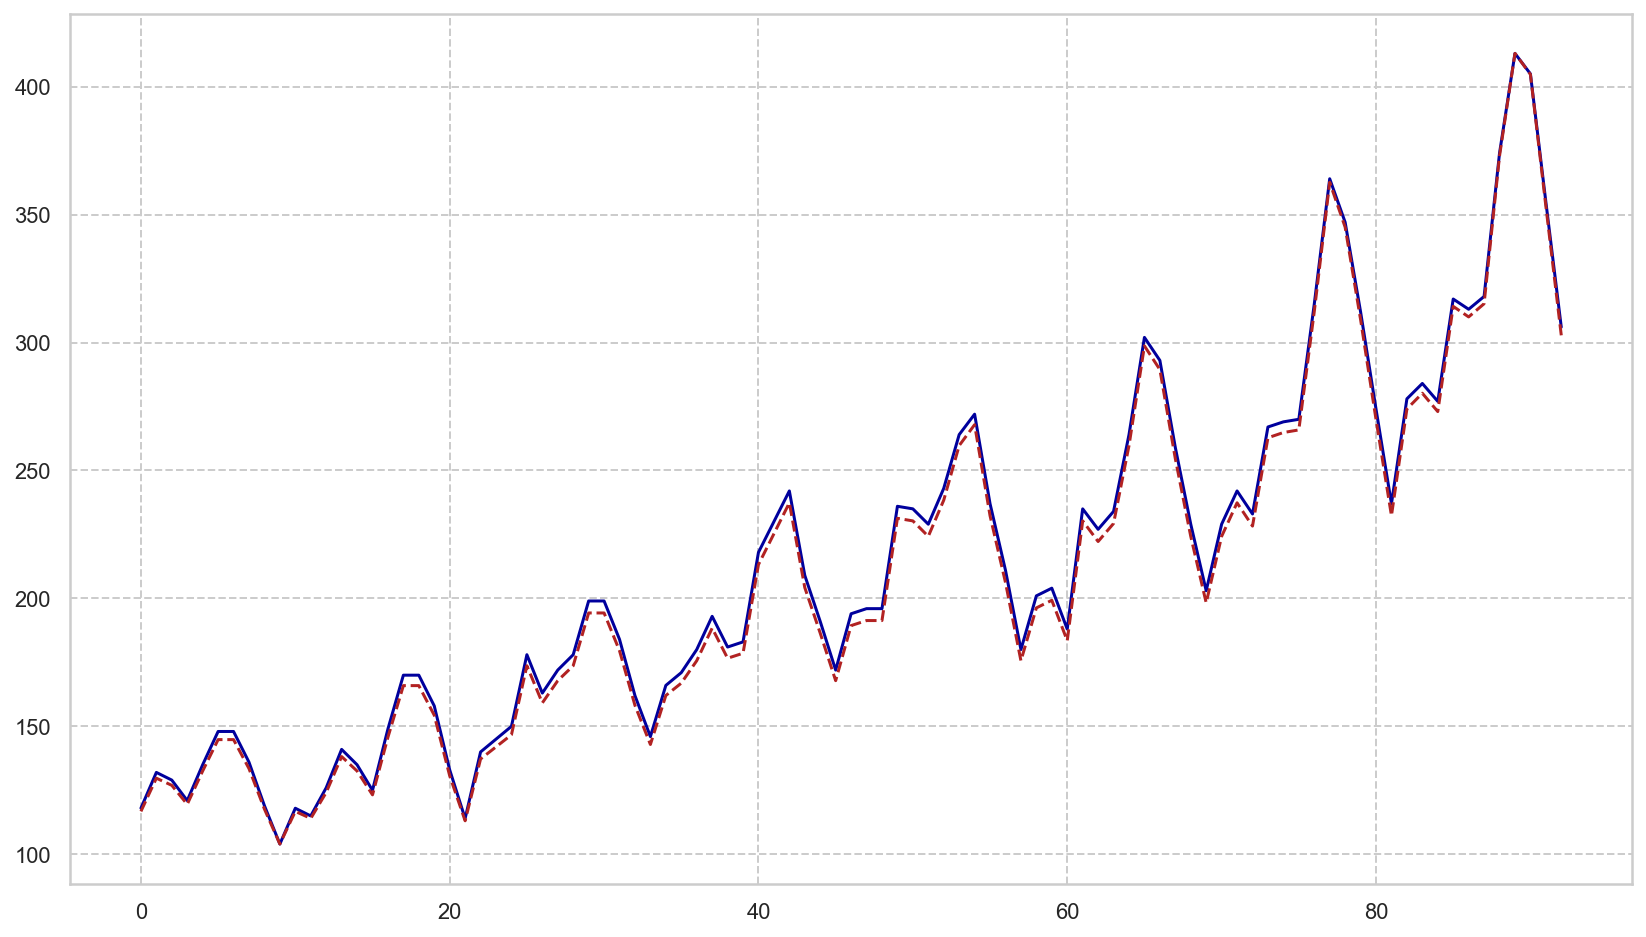

In [33]:
# create fig, axs
fig, axs = plt.subplots(1,1, figsize=(14,8))

# inverse_tranform and plot training_labels
temp = scaler_train.inverse_transform(training_labels.reshape(-1,1))
plt.plot(temp[:-look_back])

# calculate predictions
training_pred = model.predict(training_input)

# scale predictions to [0,1] and then inverse_transform back to train scale
scaler_pred = MinMaxScaler(feature_range=(0,1))
training_pred = scaler_pred.fit_transform(training_pred)
training_pred = scaler_train.inverse_transform(training_pred)

# plot
plt.plot(training_pred[look_back:], color='firebrick', linestyle='--')

In [34]:
temp = scaler_train.inverse_transform(training_labels[:10-look_back].reshape(-1,1))
df = pd.DataFrame(data=temp, columns=['training_labels'])
df['training_pred'] = training_pred[look_back:10]
df['diff'] = df['training_labels'] - df['training_pred']
df

# statistics
true_positives, false_positives, true_negatives, false_negatives, indecisive = 0, 0, 0, 0, 0
for i in range(len(df)):
    local_labels = temp1 = df['training_labels'][i]
    local_preds = df['training_pred'][i]
    if(local_preds > 0 and local_labels > 0):
        true_positives +=1
    elif(local_preds > 0 and local_labels < 0):
        false_positives +=1
    elif(local_preds < 0 and local_labels < 0):
        true_negatives +=1
    elif(local_preds < 0 and local_labels > 0):
        false_negatives +=1
    else:
        indecisive =+1
        
true_positives 
false_positives 
true_negatives
false_negatives
indecisive

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
precision # of the positive predictions, how many are correct?
recall # how many of the positives did we recall?

,training_labels,training_pred,diff
0,118.0,116.767784,1.232216
1,132.0,129.746841,2.253159
2,129.0,126.948593,2.051407
3,121.0,119.531746,1.468254
4,135.0,132.554108,2.445892
5,148.0,144.819290,3.180710
6,148.0,144.819290,3.180710
7,136.0,133.491837,2.508163
8,119.0,117.688042,1.311958


9

0

0

0

0

1.0

1.0